# The Emitter-Detector Problem

Think Bayes, Second Edition

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/radiation.ipynb)

## Modeling a radiation sensor

Here's an example from Jaynes, *Probability Theory*, page 168:

> We have a radioactive source ... which is emitting particles of some sort ... There is a rate $p$, in particles per second, at which a radioactive nucleus sends particles through our counter; and each particle passing through produces counts at the rate $\theta$. From measuring the number {c1 , c2 , . . .} of counts in different seconds, what can we say about the numbers {n1 , n2 , . . .} actually passing through the counter in each second, and
what can we say about the strength of the source?

I presented a [version of this problem](https://www.greenteapress.com/thinkbayes/html/thinkbayes015.html#sec130) in the first edition of *Think Bayes*, but I don't think I explained it well, and my solution was a bit of a mess.
In the second edition, I use more NumPy and SciPy, which makes it possible to express the solution more clearly and concisely, so let me give it another try.

As a model of the radioactive source, Jaynes suggests we imagine "$N$ nuclei, each of which has independently the probability $r$ of sending a particle through our counter in any one second".
If $N$ is large and $r$ is small, the number or particles emitted in a given second is well modeled by a Poisson distribution with parameter $s = N r$, where $s$ is the strength of the source. 

As a model of the sensor, we'll assume that "each particle passing through the counter
has independently the probability $\phi$ of making a count".
So if we know the actual number of particles, $n$, and the efficiency of the sensor, $\phi$, the distribution of the count is $\mathrm{Binomial}(n, \phi)$.

With that, we are ready to solve the problem, but first, an aside: I am not sure why Jaynes states the problem in terms of $p$ and $\theta$, and then solves it in terms of $s$ and $\phi$.
It might have been an oversight, or there might be subtle distinction he intended to draw the reader's attention to.
The book is full of dire warnings about distinctions like this, but in this case I don't see an explanation.

Anyway, following Jaynes, I'll start with a uniform prior for $s$, over a range of values wide enough to cover the region where the likelihood of the data is non-negligible.

In [3]:
import numpy as np
from empiricaldist import Pmf

ss = np.linspace(0, 350, 101)
prior_s = Pmf(1, ss)
prior_s.head()

,probs
0.0,1
3.5,1
7.0,1


For each value of $s$, the distribution of $n$ is Poisson, so we can form the joint prior of $s$ and $n$ using the `poisson` function from SciPy.
I'll use a range of values for $n$ that, again, covers the region where the likelihood of the data is non-negligible.

In [4]:
from scipy.stats import poisson

ns = np.arange(0, 350)
S, N = np.meshgrid(ss, ns)
ps = poisson(S).pmf(N)
ps.shape

(350, 101)

The result is an array with one row for each value of $n$ and one column for each value of $s$.
To get the prior probability for each pair, we multiply each row by the prior probabilities of $s$.
The following function encapsulates this computation and puts the result in a Pandas `DataFrame` that represents the joint prior.

In [5]:
import pandas as pd

def make_joint(prior_s, ns):
    ss = prior_s.qs
    S, N = np.meshgrid(ss, ns)
    ps = poisson(S).pmf(N) * prior_s.ps
    joint = pd.DataFrame(ps, index=ns, columns=ss)
    joint.index.name = 'n'
    joint.columns.name = 's'
    return joint

Here's the joint prior: 

In [6]:
joint = make_joint(prior_s, ns)
joint.head()

s,0.0,3.5,7.0,10.5,14.0,17.5,21.0,24.5,28.0,31.5,...,318.5,322.0,325.5,329.0,332.5,336.0,339.5,343.0,346.5,350.0
n,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.030197,0.000912,0.000028,8.315287e-07,2.510999e-08,7.582560e-10,2.289735e-11,6.914400e-13,2.087968e-14,...,4.755624e-139,1.436074e-140,4.336568e-142,1.309530e-143,3.954438e-145,1.194137e-146,3.605981e-148,1.088912e-149,3.288229e-151,9.929590e-153
1,0.0,0.105691,0.006383,0.000289,1.164140e-05,4.394249e-07,1.592338e-08,5.609850e-10,1.936032e-11,6.577099e-13,...,1.514666e-136,4.624158e-138,1.411553e-139,4.308354e-141,1.314851e-142,4.012300e-144,1.224230e-145,3.734968e-147,1.139371e-148,3.475357e-150
2,0.0,0.184959,0.022341,0.001518,8.148981e-05,3.844967e-06,1.671955e-07,6.872067e-09,2.710445e-10,1.035893e-11,...,2.412106e-134,7.444895e-136,2.297302e-137,7.087242e-139,2.185939e-140,6.740663e-142,2.078131e-143,6.405469e-145,1.973961e-146,6.081874e-148
3,0.0,0.215785,0.052129,0.005313,3.802858e-04,2.242898e-05,1.170368e-06,5.612188e-08,2.529749e-09,1.087688e-10,...,2.560853e-132,7.990854e-134,2.492573e-135,7.772342e-137,2.422749e-138,7.549543e-140,2.351752e-141,7.323587e-143,2.279925e-144,7.095520e-146
4,0.0,0.188812,0.091226,0.013946,1.331000e-03,9.812677e-05,6.144433e-06,3.437465e-07,1.770824e-08,8.565541e-10,...,2.039079e-130,6.432637e-132,2.028331e-133,6.392751e-135,2.013910e-136,6.341616e-138,1.996049e-139,6.279975e-141,1.974985e-142,6.208580e-144


Now we're ready to compute the likelihood of the data.
In this problem, it depends only on $n$, regardless of $s$, so we only have to compute it once for each value of $n$.

In [7]:
from scipy.stats import binom

phi = 0.1
c = 10
likelihood = binom(ns, phi).pmf(c)
likelihood.shape

(350,)

The result is an array of likelihoods, one for each value of $n$.
To do the Bayesian update, we need to multiply each column in the prior by this array of likelihoods.
We can do that using the `multiply` method with the `axis` argument.

In [8]:
product = joint.multiply(likelihood, axis=0)
product.head()

s,0.0,3.5,7.0,10.5,14.0,17.5,21.0,24.5,28.0,31.5,...,318.5,322.0,325.5,329.0,332.5,336.0,339.5,343.0,346.5,350.0
n,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following function encapsulates this computation, normalizes the result, and returns the posterior distribution.

In [9]:
from utils import normalize

def update(joint, phi, c):
    ns = joint.index
    likelihood = binom(ns, phi).pmf(c)
    posterior = joint.multiply(likelihood, axis=0)
    normalize(posterior)
    return posterior

## First update

Let's test the update function with the first example, on page 178 of *Probability Theory*:

> During the first second, `c1 = 10` counts are registered. What can [we] say about the number `n1` of particles?

Here's the update:

In [10]:
c1 = 10
phi = 0.1
posterior = update(joint, phi, c1)
posterior.head()

s,0.0,3.5,7.0,10.5,14.0,17.5,21.0,24.5,28.0,31.5,...,318.5,322.0,325.5,329.0,332.5,336.0,339.5,343.0,346.5,350.0
n,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following figures is a contour plot of the joint posterior distribution.
As you might expect, $s$ and $n$ are highly correlated; that is, if we believe $s$ is low, we should believe that $n$ is low, and contrariwise if $s$ is high.

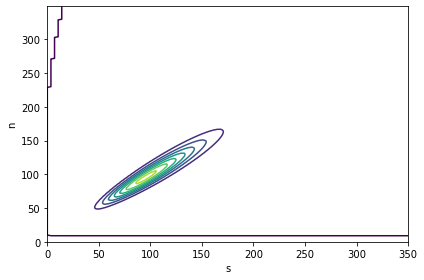

In [11]:
from utils import plot_contour

plot_contour(posterior);

From the posterior distribution, we can extract the marginal distributions of $s$ and $n$.

109.99983355767465

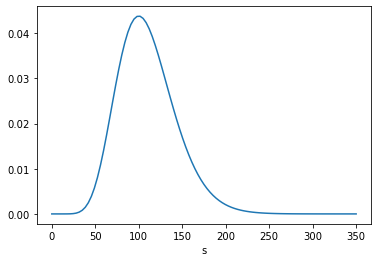

In [12]:
from utils import marginal

posterior_s = marginal(posterior, 0)
posterior_s.plot()
posterior_s.mean()

108.99984691276569

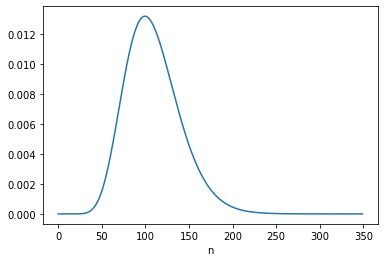

In [13]:
posterior_n = marginal(posterior, 1)
posterior_n.plot()
posterior_n.mean()

The posterior mean of $n$ is close to 109, which is consistent with Equation 6.116. 

In [14]:
posterior_n.idxmax(), c/phi

(99, 100.0)

The MAP is 99, which is one less than the analytic result in Equation 6.113, which is 100.
It looks like the posterior probabilities for 99 and 100 are the same, but the floating-point results differ slightly.

In [15]:
posterior_n[99] - posterior_n[100]

5.065392549852277e-16

## Jeffreys prior

Instead of a uniform prior for $s$, we can use a Jeffreys prior, in which the prior probability for each value of $s$ is proportional to $1/s$.
This has the advantage of "invariance under certain changes of parameters", which is "the only correct way to express complete ignorance of a scale parameter." 
However, Jaynes suggests that it is not clear "whether $s$ can properly be regarded as a scale parameter in this problem."

Nevertheless, he suggests we try it and see what happens.
Here's the Jeffreys prior for $s$.

In [16]:
prior_jeff = Pmf(1/ss[1:], ss[1:])
prior_jeff.head()

,probs
3.5,0.285714
7.0,0.142857
10.5,0.095238


We can use it to compute the joint prior of $s$ and $n$, and update it with `c1`.

In [17]:
joint_jeff = make_joint(prior_jeff, ns)
posterior_jeff = update(joint_jeff, phi, c1)

Here's the marginal posterior distribution of $n$:

99.99995605790188

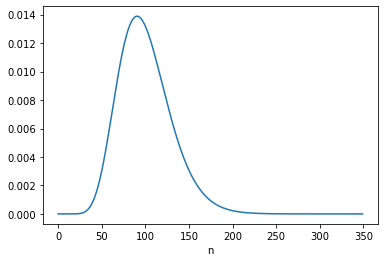

In [18]:
posterior_n = marginal(posterior_jeff, 1)
posterior_n.plot()
posterior_n.mean()

In [19]:
posterior_n.idxmax()

91

The posterior mean is close to 100 and the MAP is 91; both are consistent with the results in Equation 6.122.

## Robot A

Now we get to what I think is the most interesting part of this example, which is to take into account a second observation under two models of the scenario:

> Two robots, [A and B], have different prior information about the source of the particles.
The source is hidden in another room which A and B are not allowed to enter.
A has no knowledge at all about the source of particles; for all [it] knows, ... the other room might be full of little [people] who run back and forth, holding first one radioactive source, then another, up to the exit window. 
>
> B has one additional qualitative fact: [it] knows that the source is a radioactive sample of long lifetime, in a fixed position.

In other words, B has reason to believe that the source strength $s$ is constant from one interval to the next, while A admits the possibility that $s$ is different for each interval.

The following figure, from Jaynes, represents these models graphically (Jaynes calls them "logical situations" because he seems to be allergic to the word "model").

<img src="https://github.com/AllenDowney/ThinkBayes2/raw/master/examples/jaynes177.png" width="400">

For A, the "different intervals are logically independent", so the update with `c2 = 16` starts with the same prior.

In [20]:
c2 = 16
posterior2 = update(joint, phi, c2)

Here's the posterior marginal distribution of `n2`.

168.947980523708

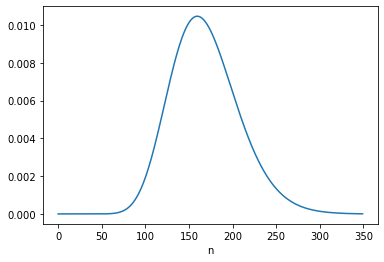

In [21]:
posterior_n2 = marginal(posterior2, 1)
posterior_n2.plot()
posterior_n2.mean()

In [22]:
posterior_n2.idxmax()

160

The posterior mean is close to 169, which is consistent with the result in Equation 6.124.
The MAP is 160, which is consistent with 6.123.

## Robot B

For B, the "logical situation" is different. If we consider $s$ to be constant, we can -- and should! -- take the information from the first update into account when we perform the second update.
We can do that by using the posterior distribution of $s$ from the first update to form the joint prior for the second update, like this:

137.499999315101

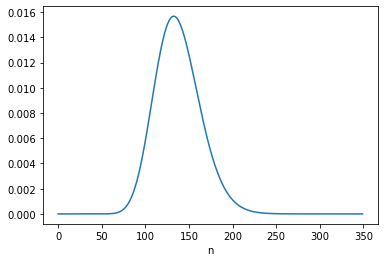

In [23]:
joint = make_joint(posterior_s, ns)
posterior = update(joint, phi, c2)
posterior_n = marginal(posterior, 1)
posterior_n.plot()
posterior_n.mean()

The posterior mean of $n$ is close to 137.5, which is consistent with Equation 6.134.
The MAP is 132, which is one less than the analytic result, 133.
But again, there are two values with the same probability except for floating-point errors.

In [24]:
posterior_n.idxmax()

132

In [25]:
posterior_n[132] - posterior_n[133]

2.914335439641036e-16

Under B's model, the data from the first interval updates our belief about $s$, which influences what we believe about `n2`.

## Going the other way

That might not seem surprising, but there is an additional point Jaynes makes with this example, which is that it also works the other way around: Having seen `c2`, we have more information about $s$, which means we can -- and should! -- go back and reconsider what we concluded about `n1`.

We can do that by imagining we did the experiments in the opposite order, so

1. We'll start again with a joint prior based on a uniform distribution for $s$,

2. Update it based on `c2`,

3. Use the posterior distribution of $s$ to form a new joint prior,

4. Update it based on `c1`, and

5. Extract the marginal posterior for `n1`.

In [26]:
joint = make_joint(prior_s, ns)
posterior = update(joint, phi, c2)
posterior_s = marginal(posterior, 0)
posterior_s.mean()

169.94393251129674

In [27]:
joint = make_joint(posterior_s, ns)
posterior = update(joint, phi, c1)
posterior_n2 = marginal(posterior, 1)
posterior_n2.mean()

131.49999935386944

The posterior mean is close to 131.5, which is consistent with Equation 6.133.
And the MAP is 126, which is one less than the result in Equation 6.132, again due to floating-point error.

In [28]:
posterior_n2.idxmax()

126

In [29]:
posterior_n2[126] - posterior_n2[127]

3.8163916471489756e-16

Here's what the new distribution of `n1` looks like compared to the original, which was based on `c1` only.

In [30]:
joint = make_joint(prior_s, ns)
posterior = update(joint, phi, c1)
posterior_n = marginal(posterior, 1)

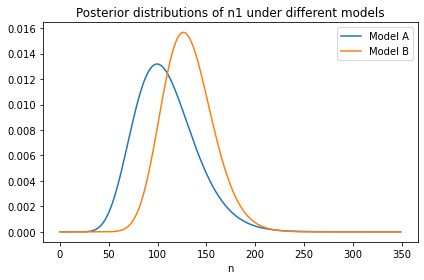

In [31]:
from utils import decorate

posterior_n.plot(label='Model A')
posterior_n2.plot(label='Model B')
decorate(title='Posterior distributions of n1 under different models')

With the additional information from `c2`:

* We give higher probability to large values of $s$, so we also give higher probability to large values of `n1`, and

* The width of the distribution is narrower, which shows that with more information about $s$, we have more information about `n1`.

This is one of several examples Jaynes uses to distinguish between "logical and causal dependence." In this example, causal dependence only goes in the forward direction: "$s$ is the physical cause which partially determines $n$; and then $n$ in turn is the physical cause which partially determines $c$".

Therefore, `c1` and `c2` are causally independent: if the number of particles counted in one interval is unusually high (or low), that does not cause the number of particles during any other interval to be higher or lower.

But if $s$ is unknown, they are not *logically* independent. For example, if `c1` is lower than expected, that implies that lower values of $s$ are more likely, which implies that lower values of `n2` are more likely, which implies that lower values of `c2` are more likely.

And, as we've seen, it works the other way, too.
For example, if `c2` is higher than expected, that implies that higher values of $s$, `n1`, and `c1` are more likely.

If you find the second result more surprising -- that is, if you think it's weird that `c2` changes what we believe about `n1` -- that implies that you are not (yet) distinguishing between logical and causal dependence.